In [1]:
import math
import warnings

from IPython.display import display
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
df = pd.ExcelFile("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls")

In [3]:
df.sheet_names

['13tbl8ny']

In [4]:
df = df.parse(sheet_name='13tbl8ny', skiprows=4)

In [5]:
df.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.0,0.0,0.0,NaN,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,NaN,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,NaN,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,NaN,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,NaN,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


In [6]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [7]:
# Creating the features df
features = df[['Population']]

In [8]:
# Checking for null cells or outliers...

df.isnull().sum()

City                                        0
Population                                  3
Violent\ncrime                              3
Murder and\nnonnegligent\nmanslaughter      3
Rape\n(revised\ndefinition)1              351
Rape\n(legacy\ndefinition)2                 3
Robbery                                     3
Aggravated\nassault                         3
Property\ncrime                             3
Burglary                                    3
Larceny-\ntheft                             3
Motor\nvehicle\ntheft                       3
Arson3                                    164
dtype: int64

In [11]:
features['Murder_raw'] = df['Murder and\nnonnegligent\nmanslaughter']
features['Larceny_theft_raw'] = df['Larceny-\ntheft']
features['Aggravated_assault_raw'] = df['Aggravated\nassault']
features['Burglary_raw'] = df['Burglary']
features['Rape_def2_raw'] = df['Rape\n(legacy\ndefinition)2']
features['Robbery_raw'] = df['Robbery']
features['Violent_Crime_raw'] = df['Violent\ncrime']
features['Property_Crime'] = df['Property\ncrime']

In [12]:
features = features.dropna(subset=['Murder_raw'])
features = features.dropna(subset=['Larceny_theft_raw'])
features = features.dropna(subset=['Aggravated_assault_raw'])
features = features.dropna(subset=['Burglary_raw'])
features = features.dropna(subset=['Rape_def2_raw'])
features = features.dropna(subset=['Robbery_raw'])
features = features.dropna(subset=['Violent_Crime_raw'])
features = features.dropna(subset=['Property_Crime'])

In [13]:
# Population squared, Murder and Robbery categorical features

features['Murder'] = 0
features['Larceny_theft'] = 0
features['Aggravated_assault'] = 0
features['Burglary'] = 0
features['Rape_def2'] = 0
features['Robbery'] = 0
features['Violent_Crime'] = 0
features.loc[(features['Murder_raw'] > 0), 'Murder'] = 1
features.loc[(features['Larceny_theft_raw'] > 0), 'Larceny_theft'] = 1
features.loc[(features['Aggravated_assault_raw'] > 0), 'Aggravated_assault'] = 1
features.loc[(features['Burglary_raw'] > 0), 'Burglary'] = 1
features.loc[(features['Rape_def2_raw'] > 0), 'Rape_def2'] = 1
features.loc[(features['Robbery_raw'] > 0), 'Robbery'] = 1
features.loc[(features['Violent_Crime_raw'] > 0), 'Violent_Crime'] = 1
features['Population_3rd'] = np.power(features['Population'],3)

In [14]:
features.head()

,Population,Murder_raw,Larceny_theft_raw,Aggravated_assault_raw,Burglary_raw,Rape_def2_raw,Robbery_raw,Violent_Crime,Property_Crime,Violent_Crime_raw,Murder,Larceny_theft,Aggravated_assault,Burglary,Rape_def2,Robbery,Population_3rd
0,1861.0,0.0,10.0,0.0,2.0,0.0,0.0,0,12.0,0.0,0,1,0,1,0,0,6.445240e+09
1,2577.0,0.0,20.0,3.0,3.0,0.0,0.0,1,24.0,3.0,0,1,1,1,0,0,1.711367e+10
2,2846.0,0.0,15.0,3.0,1.0,0.0,0.0,1,16.0,3.0,0,1,1,1,0,0,2.305179e+10
3,97956.0,8.0,3243.0,526.0,705.0,30.0,227.0,1,4090.0,791.0,1,1,1,1,1,1,9.399248e+14
4,6388.0,0.0,165.0,16.0,53.0,3.0,4.0,1,223.0,23.0,0,1,1,1,1,1,2.606722e+11


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Population')

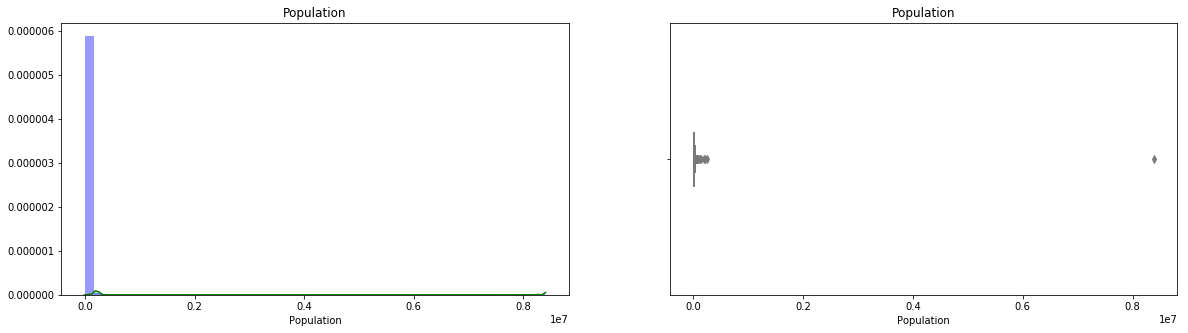

In [15]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(121)
sns.distplot(features['Population'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population')

fig.add_subplot(122)
sns.boxplot(features['Population'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population')

In [16]:
print(np.sort(features.Population)[-10:])

[  80705.   87204.   96667.   97956.  118296.  143834.  199134.  210562.
  258789. 8396126.]


In [17]:
features['Population'] = features[features.Population < 140000.0]
features = features.dropna(subset=['Population'])

In [18]:
features['Population_log'] = np.log(features['Population'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Population_log')

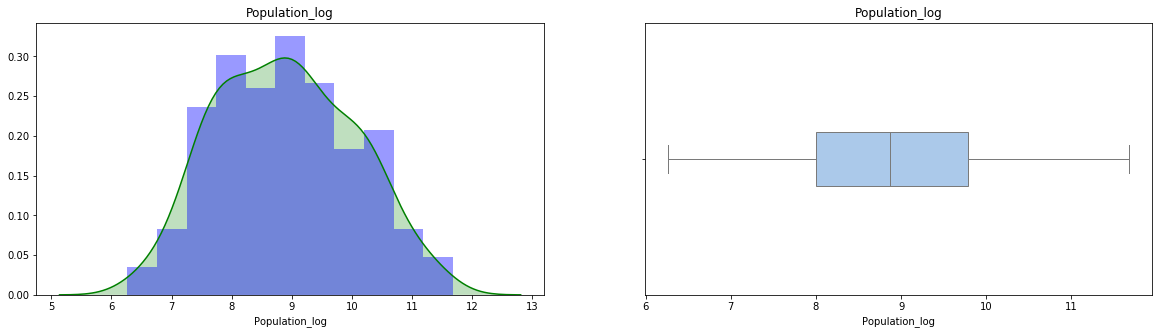

In [19]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(121)
sns.distplot(features['Population_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population_log')

fig.add_subplot(122)
sns.boxplot(features['Population_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population_log')

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Robbery_raw')

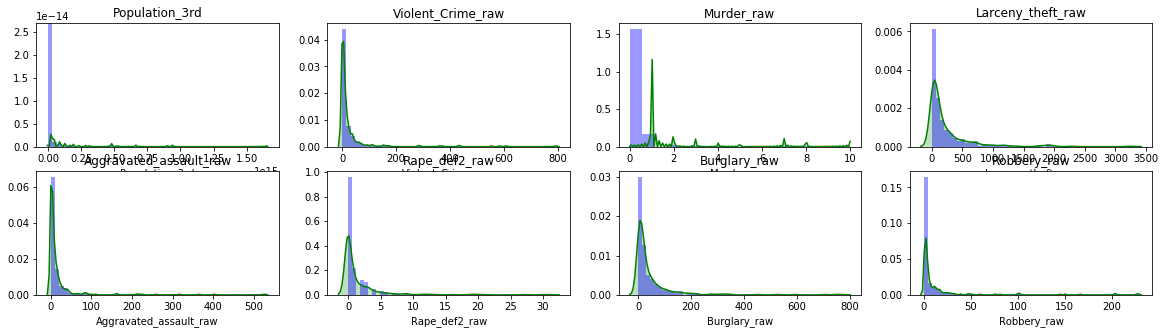

In [20]:
fig = plt.figure(figsize=(20,5))

fig.add_subplot(241)
sns.distplot(features['Population_3rd'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population_3rd')

fig.add_subplot(242)
sns.distplot(features['Violent_Crime_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Violent_Crime_raw')

fig.add_subplot(243)
sns.distplot(features['Murder_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Murder_raw')

fig.add_subplot(244)
sns.distplot(features['Larceny_theft_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Larceny_theft_raw')

fig.add_subplot(245)
sns.distplot(features['Aggravated_assault_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Aggravated_assault_raw')

fig.add_subplot(246)
sns.distplot(features['Rape_def2_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Rape_def2_raw')

fig.add_subplot(247)
sns.distplot(features['Burglary_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Burglary_raw')

fig.add_subplot(248)
sns.distplot(features['Robbery_raw'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Robbery_raw')

***Murder, Rape2, Violent Crime and Robbery should be kept as binary categorical***

In [23]:
features['Population_3rd_log'] = np.log(features['Population_3rd'])
features['Larceny_theft_log'] = np.log(features['Larceny_theft_raw'])
features['Aggravated_assault_log'] = np.log(features['Aggravated_assault_raw'])
features['Burglary_log'] = np.log(features['Burglary_raw'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0.5,1,'Burglary_log')

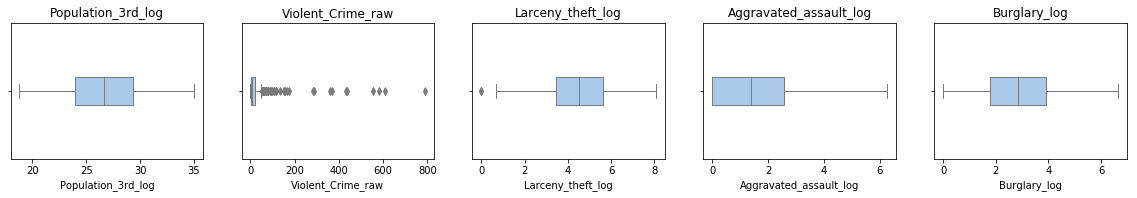

In [22]:
fig = plt.figure(figsize=(20,2.5))

fig.add_subplot(151)
sns.boxplot(features['Population_3rd_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Population_3rd_log')

fig.add_subplot(152)
sns.boxplot(features['Violent_Crime_raw'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Violent_Crime_raw')

fig.add_subplot(153)
sns.boxplot(features['Larceny_theft_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Larceny_theft_log')

fig.add_subplot(154)
sns.boxplot(features['Aggravated_assault_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Aggravated_assault_log')

fig.add_subplot(155)
sns.boxplot(features['Burglary_log'], linewidth=1, width=0.2, palette='pastel', orient='h')
plt.title('Burglary_log')

In [24]:
# Checking for '-inf' after log transformations...

features[features == np.inf].sum()
features[features == -np.inf].sum()

Population                0.000000
Murder_raw                0.000000
Larceny_theft_raw         0.000000
Aggravated_assault_raw    0.000000
Burglary_raw              0.000000
Rape_def2_raw             0.000000
Robbery_raw               0.000000
Violent_Crime             0.000000
Property_Crime            0.000000
Violent_Crime_raw         0.000000
Murder                    0.000000
Larceny_theft             0.000000
Aggravated_assault        0.000000
Burglary                  0.000000
Rape_def2                 0.000000
Robbery                   0.000000
Population_3rd            0.000000
Population_log            0.000000
Population_3rd_log        0.000000
Larceny_theft_log             -inf
Aggravated_assault_log        -inf
Burglary_log                  -inf
Violent_Crime_log             -inf
dtype: float64

In [25]:
features['Larceny_theft_log'] = features['Larceny_theft_log'].replace([np.inf, -np.inf], np.nan)
features = features.dropna(subset=['Larceny_theft_log'])
features['Aggravated_assault_log'] = features['Aggravated_assault_log'].replace([np.inf, -np.inf], np.nan)
features = features.dropna(subset=['Aggravated_assault_log'])
features['Burglary_log'] = features['Burglary_log'].replace([np.inf, -np.inf], np.nan)
features = features.dropna(subset=['Burglary_log'])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Burglary_log')

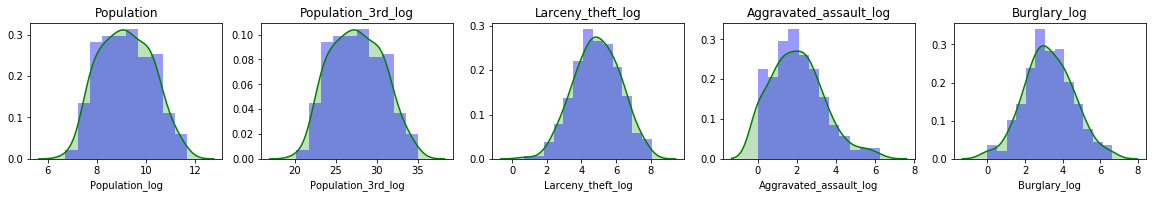

In [26]:
fig = plt.figure(figsize=(20,2.5))

fig.add_subplot(151)
sns.distplot(features['Population_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population')

fig.add_subplot(152)
sns.distplot(features['Population_3rd_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Population_3rd_log')

fig.add_subplot(153)
sns.distplot(features['Larceny_theft_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Larceny_theft_log')

fig.add_subplot(154)
sns.distplot(features['Aggravated_assault_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Aggravated_assault_log')

fig.add_subplot(155)
sns.distplot(features['Burglary_log'], hist=True, color='b', kde_kws={'shade':True,'color':'g'})
plt.title('Burglary_log')

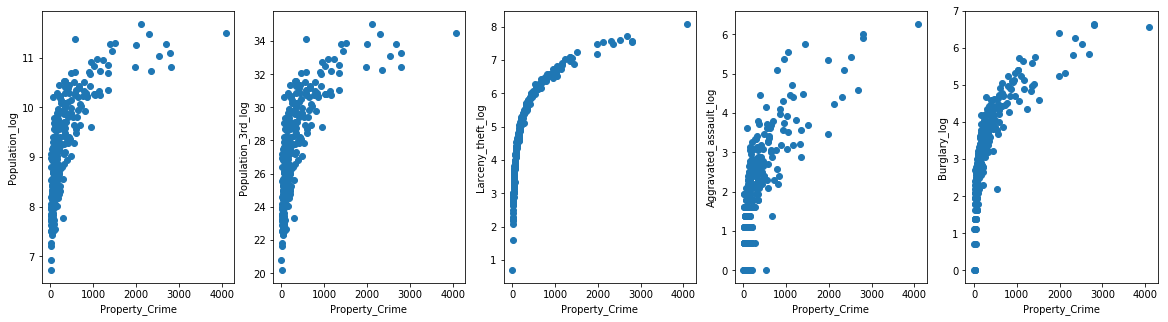

In [27]:
# Linear Relationship

fig = plt.figure(figsize=(20,5))

fig.add_subplot(151)
plt.scatter(features['Property_Crime'],features['Population_log'])
plt.ylabel('Population_log')
plt.xlabel('Property_Crime')

fig.add_subplot(152)
plt.scatter(features['Property_Crime'],features['Population_3rd_log'])
plt.ylabel('Population_3rd_log')
plt.xlabel('Property_Crime')

fig.add_subplot(153)
plt.scatter(features['Property_Crime'],features['Larceny_theft_log'])
plt.ylabel('Larceny_theft_log')
plt.xlabel('Property_Crime')

fig.add_subplot(154)
plt.scatter(features['Property_Crime'],features['Aggravated_assault_log'])
plt.ylabel('Aggravated_assault_log')
plt.xlabel('Property_Crime')

fig.add_subplot(155)
plt.scatter(features['Property_Crime'],features['Burglary_log'])
plt.ylabel('Burglary_log')
plt.xlabel('Property_Crime')

plt.show()

In [53]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
y = features['Property_Crime']
X = features[['Population_3rd_log','Larceny_theft_log','Robbery','Murder']]
regr.fit(X, y)

# 'Population_log'
# 'Population_3rd_log'
# 'Larceny_theft_log'
# 'Aggravated_assault_log'
# 'Burglary_log'
# 'Robbery'
# 'Murder'
# 'Rape_def2'

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, y))


Coefficients: 
 [  23.12458839  284.40733752 -213.96418068  246.24133539]

Intercept: 
 -1552.9807992487363

R-squared:
0.6302699566516858


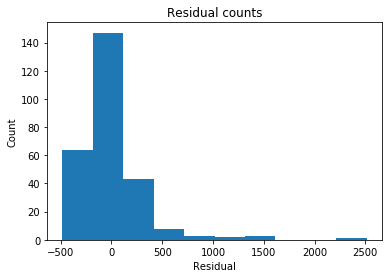

In [54]:
# Multivariate Normality

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = features['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

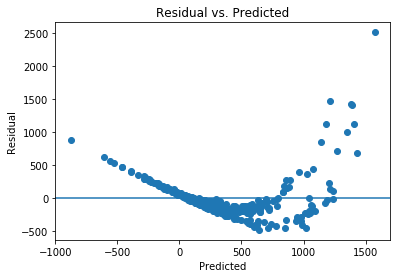

In [55]:
# Homoscedasticity

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [56]:
# Multicollinearity

correlation_matrix = X.corr()
display(correlation_matrix)

,Population_3rd_log,Larceny_theft_log,Robbery,Murder
Population_3rd_log,1.000000,0.837248,0.500004,0.437972
Larceny_theft_log,0.837248,1.000000,0.610560,0.429983
Robbery,0.500004,0.610560,1.000000,0.257786
Murder,0.437972,0.429983,0.257786,1.000000


# Test Statistics

In [58]:
linear_formula = 'Property_Crime ~ Population_3rd_log+Larceny_theft_log+Robbery+Murder'
lm = smf.ols(formula=linear_formula, data=features).fit()
print(lm.params)
print('\n')
print(lm.pvalues)
print('\n')
print(lm.rsquared)
print(lm.conf_int())

Intercept            -1552.980799
Population_3rd_log      23.124588
Larceny_theft_log      284.407338
Robbery               -213.964181
Murder                 246.241335
dtype: float64


Intercept             1.245573e-10
Population_3rd_log    5.451006e-02
Larceny_theft_log     1.813336e-17
Robbery               1.910790e-04
Murder                8.419962e-05
dtype: float64


0.6302699566516857
                              0            1
Intercept          -2009.423803 -1096.537796
Population_3rd_log    -0.450643    46.699820
Larceny_theft_log    223.054325   345.760350
Robbery             -325.310797  -102.617564
Murder               124.845722   367.636949


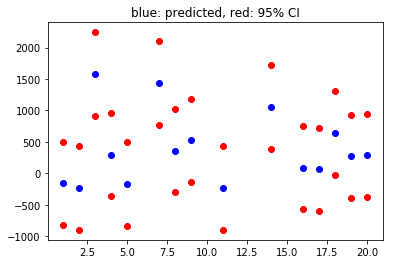

In [59]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()